In [1]:
import numpy as np
import pandas as pd
from IPython.display import display 

### Training and test set
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import Imputer, StandardScaler

from imblearn.over_sampling import SMOTE

from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression
from sklearn.base import clone
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from mlxtend.classifier import StackingClassifier
from mlens.visualization import corrmat
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
[MLENS] backend: threading


In [2]:
df = pd.read_csv('./all/health-diagnostics-train.csv')
test = pd.read_csv('./all/health-diagnostics-test.csv')

df.replace('#NULL!',np.nan, inplace=True)
df.iloc[:, 0:(len(df.columns)-1)] = df.select_dtypes(include='object').apply(pd.to_numeric)
df.dropna(inplace=True)
test.replace('#NULL!',np.nan, inplace=True)
test = test.select_dtypes(include='object').apply(pd.to_numeric)
imp = Imputer(strategy='most_frequent')
imp.fit(test)
F_test = imp.transform(test)

In [3]:
X = df.drop('target',axis=1)
F_test = pd.DataFrame(F_test, columns=X.columns)
X.reset_index(drop=True, inplace=True)
y=df['target']
y.reset_index(drop=True, inplace=True)

In [4]:
seed = 47
np.random.seed(seed)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

In [18]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()

In [6]:
def get_models():
    lrc = LogisticRegression(C=10, class_weight='balanced', random_state=seed)
    
    sgd = SGDClassifier(loss='log', class_weight={0:0.01,1:0.99}, random_state=seed)
    
    rfc = RandomForestClassifier(
        n_estimators=40,
        max_depth=2,
        min_samples_leaf=0.003,
        class_weight={0:0.01,1:0.99},
        max_features='auto',
        random_state=seed
    )
    
    models = {
        'lrc':lrc,
        'sgd':sgd,
        'rfc':rfc
    }
    return models

In [7]:
def train_base_learners(base_learners, inp, out, verbose=True):
    """Train all base learners in the library."""
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: 
            print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        if verbose: print("done")

In [8]:
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """Generate a prediction matrix."""
    P = np.zeros((inp.shape[0], len(pred_base_learners)))

    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: 
            print("%s..." % name, end=" ", flush=False)
        p = m.predict_proba(inp)
        P[:, i] = p[:, 1]
        if verbose: print("done")
    return P

In [9]:
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """Generate predictions from the ensemble."""
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict(P_pred)

In [10]:
def stacking(base_learners, meta_learner, X_stack, y_stack, generator):
    print("Fitting final base learners...", end="")
    train_base_learners(base_learners, X_stack, y_stack, verbose=False)
    print("done")
    kf = KFold(n_splits=10, random_state=seed)
    cv_preds, cv_y = [], []
    for i, (train_idx, test_idx) in enumerate(kf.split(X_stack)):
        fold_xtrain, fold_ytrain = X_stack.iloc[train_idx, :], y_stack.iloc[train_idx]
        fold_xtest, fold_ytest = X_stack.iloc[test_idx, :], y_stack.iloc[test_idx]
        
        # Inner loop: step 4 and 5
        fold_base_learners = {name: clone(model) for name, model in base_learners.items()}
        train_base_learners(fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)
        fold_P_base = predict_base_learners(fold_base_learners, fold_xtest, verbose=False)

        cv_preds.append(fold_P_base)
        cv_y.append(fold_ytest)
        print("Fold %i done" % (i + 1))

    np.vstack(cv_preds)
    X_meta = np.vstack(cv_preds)
    y_meta = np.hstack(cv_y)
    meta_learner.fit(X_meta, y_meta)
    return base_learners, meta_learner

In [11]:
meta_rfc = RandomForestClassifier(
    n_estimators=25, 
    max_depth=1, 
    max_features=2, 
    class_weight={0:0.01, 1:0.99})

In [21]:
weak_learners, meta_learner = stacking(get_models(), meta_rfc, X_train, y_train, KFold(n_splits=10, random_state=seed))

Fitting final base learners...

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


done


/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fold 1 done


/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fold 2 done


/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fold 3 done


/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fold 4 done


/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fold 5 done


/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fold 6 done


/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fold 7 done


/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fold 8 done


/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fold 9 done


/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fold 10 done


In [22]:
P, y_pred = ensemble_predict(weak_learners, meta_learner, X_test)

Generating base learner predictions.
lrc... done
sgd... done
rfc... done


In [23]:
test = pd.DataFrame(P, columns=['lrc','sgd','rfc'])

In [24]:
x=0.8
y=0.8
z=0.5
v=1
boundaries = {'lrc':x, 'sgd':y, 'rfc':z}
votes = {}
for model in test.columns:
    votes[model] = np.where(test[model]>boundaries[model],1,0)

votes_df = pd.DataFrame(votes)
votes_df['total_votes'] = votes_df.sum(axis=1)
predictions = np.where(votes_df['total_votes']>v,1,0)

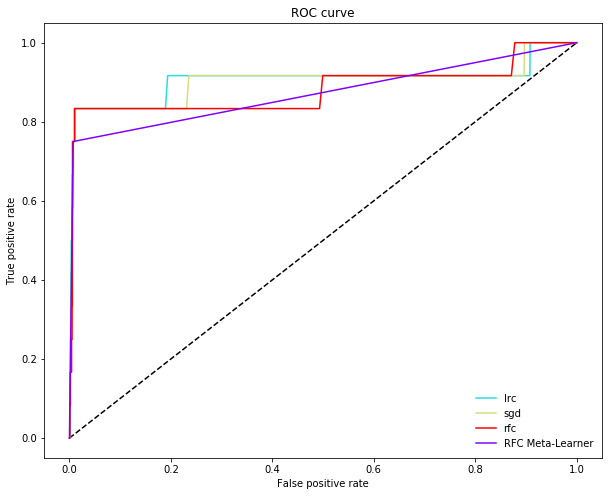

In [32]:
plot_roc_curve(y_test, test.values, y_pred, test.columns, "RFC Meta-Learner")

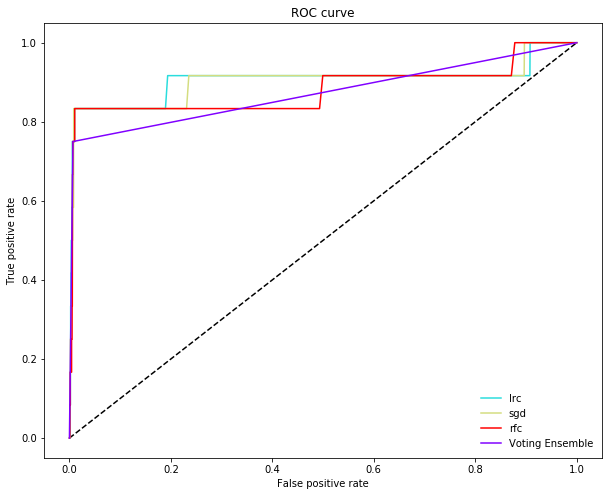

In [33]:
plot_roc_curve(y_test, test.values, np.where(votes_df.total_votes>1,1,0), test.columns, "Voting Ensemble")